# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


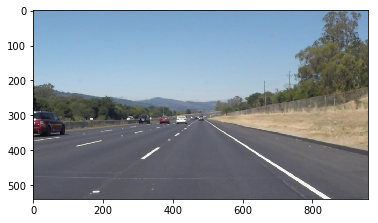

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(image, lines, color=[255, 0, 0], thickness=2,
               midpoint_interval=(10, 10), solid_lines=False):
    """
    `image` is the original, three channel, image array.
    
    `lines` is the raw data comes from a hough transform.
    
    `color` defines what color the lane line markings will be.
    
    `thickness` is the thickness of the marking lines (in pixels).
    
    `midpoint_interval` is the right and left padding for the left and right solid 
    line markings (in pixels).
    
    `solid_lines` defines the type of the markings. If the value is `True` then the
    left and right lane lines will be marked with two separated solid lines. If the 
    value is `False` than the lane lines will be marked with the raw data comes from 
    hough transfrom.
    
    Returns an image with lane line markings applied.
    """
    
    xsize = image.shape[1]
    ysize = image.shape[0]
    
    def solid_lined_image(image, lines, xsize=xsize, ysize=ysize):
        """
        `image` is the original image array. `lines` is the line coordinates we get after
        a Hough transform. `xsize` and the `ysize` defines the width and the height of
        the image respectively.
        
        Returns the original image with solid lane markings on it.
        """
    
        def solid_lines_fit(lines, xsize=xsize, ysize=ysize):
            """
            `lines` is the line coordinates we get after the Hough transform.
            
            `xsize` and the `ysize` defines the width and the height of
            the image respectively.
            
            This function applies a polynomial (a linear function like y=m*x+b) fit using the
            raw data of coordinates(`lines`) comes from a Hough transform. And returns an image 
            with two separate lane line markings applied.
            """
            
            def linear_fit(x, y):
                """
                `x` and `y` are the coordinates of marked lane line pixels on the image.
                
                Returns the slope and intercept for a line fits the data.
                """
                if(len(x) > 0 and len(y) > 0):
                    return np.polyfit(x, y, 1)
                else:
                    return 0, 0
        
            def line_coors(lines):
                """
                `lines` is the line coordinates we get after the Hough transform.
                
                Returns the x and y coordinates of two separated solid lines indicating
                the lane lines.
                """
                
                line1_x, line1_y = [], []
                line2_x, line2_y = [], []
                if lines is not None:
                    for line in lines:
                        for x1,y1,x2,y2 in line:
                            m, b = linear_fit([x1,x2],[y1,y2])
                            if m < 0:
                                line1_x.append(x1)
                                line1_x.append(x2)
                                line1_y.append(y1)
                                line1_y.append(y2)
                            else:
                                line2_x.append(x1)
                                line2_x.append(x2)
                                line2_y.append(y1)
                                line2_y.append(y2)
                return line1_x, line1_y, line2_x, line2_y
        
            line1_x, line1_y, line2_x, line2_y = line_coors(lines)
            
            m1, b1 = linear_fit(line1_x, line1_y)
            m2, b2 = linear_fit(line2_x, line2_y)
        
            fit1_x, fit1_y = [], []
            if lines is not None:
                for x in np.arange(0, xsize // 2 - midpoint_interval[0]):
                    y = int(x * m1 + b1)
                    if y < ysize:
                        fit1_x.append(x)
                        fit1_y.append(y)
                
            fit2_x, fit2_y = [], []
            if lines is not None:
                for x in np.arange(xsize // 2 + midpoint_interval[1], xsize):
                    y = int(x * m2 + b2)
                    if y < ysize:
                        fit2_x.append(x)
                        fit2_y.append(y)
            
            return fit1_x, fit1_y, fit2_x, fit2_y
        
        fit1_x, fit1_y, fit2_x, fit2_y = solid_lines_fit(lines, xsize, ysize)
        overlay = image.copy()
        if len(fit1_x) > 0 and len(fit1_y) > 0:
            cv2.line(overlay, (fit1_x[0], fit1_y[0]), 
                     (fit1_x[-1], fit1_y[-1]), color, thickness=10)
        if len(fit2_x) > 0 and len(fit2_y) > 0:
            cv2.line(overlay, (fit2_x[0], fit2_y[0]), 
                     (fit2_x[-1], fit2_y[-1]), color, thickness=10)
        opacity = 0.3
        image = weighted_img(image, overlay, α=opacity, β=1.-opacity, λ=0.)
        return image
    
    if solid_lines:
        image = solid_lined_image(image, lines)
    else:
        line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        if lines is not None:
            for line in lines:
                for x1,y1,x2,y2 in line:
                    cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
        image = weighted_img(line_image, image, α=0.2, β=1, λ=0.)
    
    return image

def hough_lines(image, transformed_img, rho, theta, threshold, 
                min_line_len, max_line_gap, 
                clean_horizontals=False, solid_lines=False):
    """
    `transformed_img` should be the output of a Canny transform.
    
    If `clean_horizonrals` is `True` then the horizontal lines will be
    cleaned from `lines` data.
    
    If `solid_lines` is `True` then the returning image will contain two
    separate solid line markings.
        
    Returns an image with hough lines drawn.
    """
    
    def clean_horizontal_lines(lines):
        """
        This function is an extension for the funciton `hough_lines`.
        
        `lines` is the data of line coordinates comes from the output of a Hough
        transform.
        
        This function computes the slope of each line and discards the horizontal
        ones using the `threshold` value. And returns the remaining data.
        """
        
        def linear_fit(x, y):
            """
            `x` and `y` are the coordinates of marked lane line pixels on the image.
                
            Returns the slope and intercept for a line fits the data.
            """
            if(len(x) > 0 and len(y) > 0):
                return np.polyfit(x, y, 1)
            else:
                return 0, 0
    
        threshold = 0.5
        cleaned = []
        if lines is not None:
            for line in lines:
                for x1,y1,x2,y2 in line:
                    m, b = linear_fit([x1,x2],[y1,y2])
                    if abs(m) > threshold:
                        cleaned.append([[x1,y1,x2,y2]])
            return cleaned
        else:
            return lines
    
    lines = cv2.HoughLinesP(transformed_img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    if clean_horizontals:
        lines = clean_horizontal_lines(lines)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

solidYellowLeft.jpg


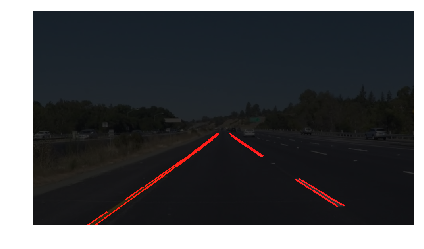

solidYellowCurve.jpg


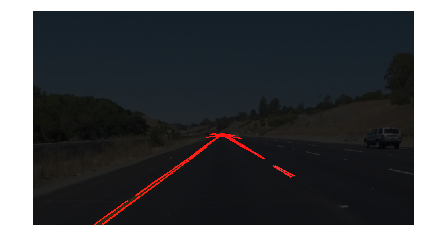

whiteCarLaneSwitch.jpg


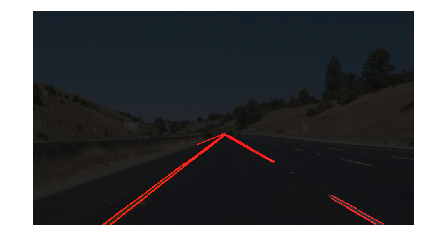

solidWhiteRight.jpg


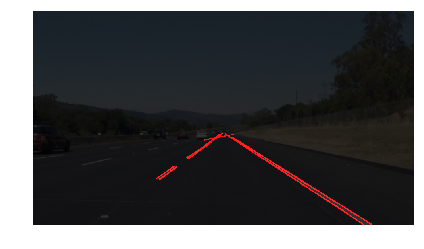

solidWhiteCurve.jpg


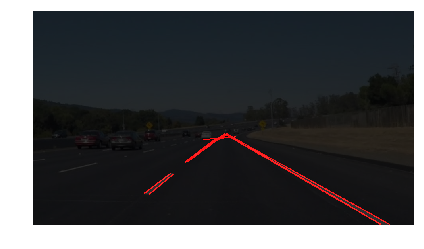

solidYellowCurve2.jpg


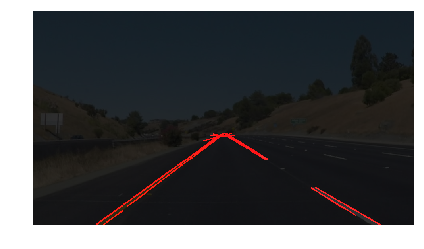

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Create directories
paths = ['transformations/test_images_grayscale', 'transformations/test_images_blur', 
         'transformations/test_images_edges', 'transformations/test_images_masked', 
         'test_images_output', 'test_videos_output']

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

# Parameters
# Masking parameters
vertices = np.array([[(130, 540), (450, 310), (500, 310), 
                          (960, 540)]], dtype=np.int32)
# Gaussian Blur parameters
kernel_size = 5
# Canny transform parameters
low_threshold = 50
high_threshold = 150
# Hough transform parameters
rho=2
theta=np.pi/180
hough_threshold=15
min_line_len=40
max_line_gap=20

# A helper function
def mark_lane_lines(image, rho=rho, theta=theta, hough_threshold=hough_threshold,
                        min_line_len=min_line_len, max_line_gap=max_line_gap,
                        vertices=vertices, low_threshold=low_threshold, 
                        high_threshold=high_threshold, kernel_size=kernel_size,
                        clean_horizontals=False, solid_lines=False,
                        midpoint_interval=(10, 10), return_transforms=False):
    """
    Applies grayscale transform, Gaussian smoothing and
    Canny transform to `image` object.
    
    `image` is the original image array with three color channles.
    
    `rho`, `theta`, `hough_threshold`, `min_line_len` and `max_line_gap`
    parameters are for the Hough transform.
    
    `vertices` is coordinates of a polygon and used for to mask the relevant 
    region for the lane lines on the image.
    
    `low_threshold` and `high_threshold` are for the Canny transform.
    
    `kernel_size` is for Gaussian blurring.
    
    If `clean_horizonrals` is `True` then the horizontal lines will be
    cleaned from `lines` data.
    
    If `solid_lines` is `True` then the returning image will contain two
    separate solid line markings. Otherwise only the raw lines will be drawn.
    
    `midpoint_interval` is the right and left padding for the left and right solid 
    line markings (in pixels).
    
    Returns the original image with marked lane lines and if `return_transforms` is
    `True`, then also returns a tuple of other transformed images.
    """
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size)
    # Get edges
    edges = canny(blur_gray, low_threshold, high_threshold)
    # Mask the images
    masked_edges = region_of_interest(edges, vertices)
    lines = hough_lines(image, masked_edges, rho=rho, theta=theta, 
                                     threshold=hough_threshold,
                                     min_line_len=min_line_len, 
                                     max_line_gap=max_line_gap,
                                     clean_horizontals=clean_horizontals)
    # Mark lane lines
    marked_image = draw_lines(image, lines, 
                              midpoint_interval=midpoint_interval, 
                              solid_lines=solid_lines)
    transformed_imgs = (gray, blur_gray, edges, masked_edges)
    
    if return_transforms:
        return marked_image, transformed_imgs
    else:
        return marked_image


# Get file names of test images
image_names = os.listdir("test_images/")

    
# Read the test images and apply grayscale transform,
# Gaussian smoothing, Canny transform
# And show results
for name in image_names:
    print(name)
    image = mpimg.imread("test_images/" + name)
    marked_image, transforms = mark_lane_lines(image, return_transforms=True)
    
    plt.imshow(transforms[0], cmap="gray")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('transformations/test_images_grayscale/' + name,
                   figsize=(960/133, 540/133), dpi=133)
    
    plt.imshow(transforms[1], cmap="gray")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('transformations/test_images_blur/' + name,
                   figsize=(960/133, 540/133), dpi=133)
    
    plt.imshow(transforms[2], cmap="gray")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('transformations/test_images_edges/' + name,
                   figsize=(960/133, 540/133), dpi=133)
    
    plt.imshow(transforms[3], cmap="gray")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('transformations/test_images_masked/' + name,
                   figsize=(960/133, 540/133), dpi=133)
    
    plt.imshow(marked_image, cmap="gray")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('test_images_output/' + name[:-4] + '_raw.jpg',
                   figsize=(960/133, 540/133), dpi=133)
    plt.show()

Now we can draw solid lines on the original images 

solidYellowLeft.jpg


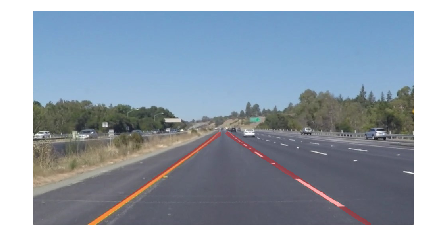

solidYellowCurve.jpg


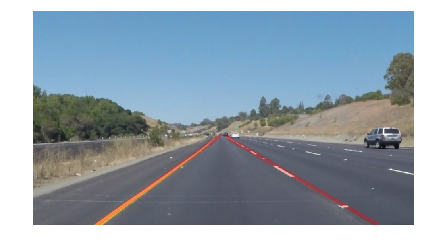

whiteCarLaneSwitch.jpg


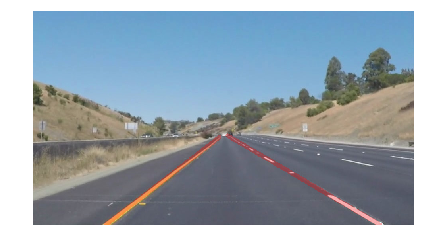

solidWhiteRight.jpg


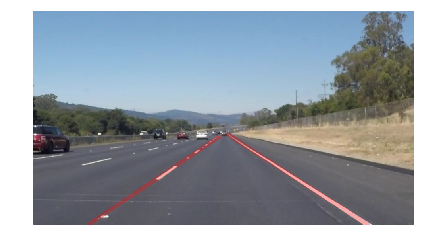

solidWhiteCurve.jpg


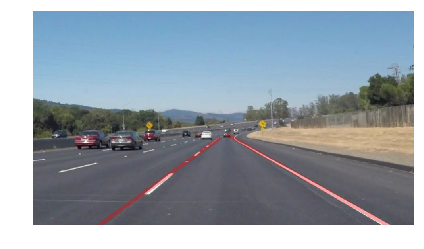

solidYellowCurve2.jpg


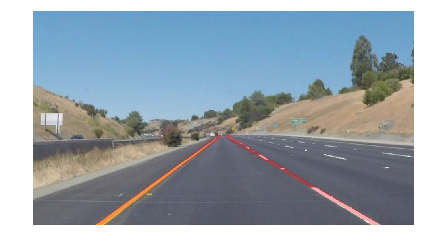

In [6]:
for name in image_names:
    print(name)
    image = mpimg.imread("test_images/" + name)
    marked_image = mark_lane_lines(image, solid_lines=True)
    plt.imshow(marked_image, cmap="gray")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('test_images_output/' + name[:-4] + '_raw.jpg',
                   figsize=(960/133, 540/133), dpi=133)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return mark_lane_lines(image, solid_lines=True)

def process_raw_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return mark_lane_lines(image, solid_lines=False)

Let's try the one with the solid white lane line on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,2)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:16<00:00,  8.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1min 42s, sys: 3.06 s, total: 1min 45s
Wall time: 17.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

It looks ok, but lines do not seem stable. let's see the raw lines on the same video.

In [11]:
white_output = 'test_videos_output/solidWhiteRight_raw.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_raw_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_raw.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_raw.mp4


100%|█████████▉| 221/222 [00:11<00:00, 19.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_raw.mp4 

CPU times: user 1min 12s, sys: 2.26 s, total: 1min 14s
Wall time: 11.6 s


Some horizontal lines appears at the horizon, lowering the height of the mask can be a solution but it doesn't guarantee that will not happen with different driving footages. For example let's see the challenge video with raw lines drawn on it.

In [12]:
white_output = 'test_videos_output/challenge_raw.mp4'
clip = VideoFileClip("test_videos/challenge.mp4")
clip = clip.resize(height=540)
white_clip = clip.fl_image(process_raw_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/challenge_raw.mp4
[MoviePy] Writing video test_videos_output/challenge_raw.mp4


100%|██████████| 251/251 [00:24<00:00, 10.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_raw.mp4 

CPU times: user 2min, sys: 3.82 s, total: 2min 4s
Wall time: 25.8 s


Horizontal lines appears not only on the horizon but also on the other segments of the masked region, especially when shadow drops on the road. So lets use a clean-out method we already implemented above and check again.

In [13]:
def process_cleaned_image(image):
    """
    Cleans the horizontal lines and returns lane lines marked with solid lines.
    """
    return mark_lane_lines(image, clean_horizontals=True, solid_lines=True)

def process_cleaned_raw_image(image):
    """
    Cleans the horizontal lines and returns lane lines marked raw lines.
    """
    return mark_lane_lines(image, clean_horizontals=True, solid_lines=False)

In [14]:
white_output = 'test_videos_output/challenge_cleaned_raw.mp4'
clip = VideoFileClip("test_videos/challenge.mp4")
clip = clip.resize(height=540)
white_clip = clip.fl_image(process_cleaned_raw_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/challenge_cleaned_raw.mp4
[MoviePy] Writing video test_videos_output/challenge_cleaned_raw.mp4


100%|██████████| 251/251 [00:18<00:00,  6.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_cleaned_raw.mp4 

CPU times: user 1min 53s, sys: 3.42 s, total: 1min 57s
Wall time: 19.8 s


We discarded the lines with a slope value of approximately zero and all the horizontal lines are finally gone, even the ones appear on the hood. Now lets go on and draw solid lines on each video but this time with cleaned data.

First, again with the video named 'solidWhiteRight.mp4'.

In [15]:
white_output = 'test_videos_output/solidWhiteRight_cleaned_raw.mp4'
clip = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip.fl_image(process_cleaned_raw_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_cleaned_raw.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_cleaned_raw.mp4


100%|█████████▉| 221/222 [00:11<00:00, 19.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_cleaned_raw.mp4 

CPU times: user 1min 12s, sys: 2.18 s, total: 1min 14s
Wall time: 11.7 s


Horizontal lines are gone. And now, let's draw solid markers for the lane lines.

In [16]:
white_output = 'test_videos_output/solidWhiteRight_cleaned.mp4'
clip = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip.fl_image(process_cleaned_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_cleaned.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_cleaned.mp4


100%|█████████▉| 221/222 [00:17<00:00, 12.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_cleaned.mp4 

CPU times: user 1min 43s, sys: 3.52 s, total: 1min 47s
Wall time: 17.8 s


It looks stable now.

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [17]:
def process_cleaned_image_yellow_solid(image):
    """
    Cleans the horizontal lines and returns lane lines marked with solid lines.
    """
    return mark_lane_lines(image, clean_horizontals=True, 
                           solid_lines=True, midpoint_interval=(25, 30))


yellow_output = 'test_videos_output/solidYellowLeft_cleaned.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_cleaned_image_yellow_solid)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_cleaned.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_cleaned.mp4


100%|█████████▉| 681/682 [01:00<00:00, 11.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_cleaned.mp4 

CPU times: user 6min 14s, sys: 11.4 s, total: 6min 26s
Wall time: 1min 1s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
def process_cleaned_challenge_image(image):
    """
    Cleans the horizontal lines and returns lane lines marked with solid lines.
    """
    return mark_lane_lines(image, clean_horizontals=True, 
                           solid_lines=True, midpoint_interval=(20, 60))

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may alimageso uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,1)
clip3 = VideoFileClip('test_videos/challenge.mp4')
clip3 = clip3.resize(height=540)
challenge_clip = clip3.fl_image(process_cleaned_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))